In [1]:
%matplotlib inline

import cPickle as pickle
import sys
import theano as theano
import theano.tensor as T
import operator
import csv
import itertools
import operator
import numpy as np
import nltk
from datetime import datetime
from utils import *
import matplotlib.pyplot as plt

sys.path.append('../')

from preprocessing.trainingdata import TrainingData

def load(filename):
    return pickle.load(open(filename, 'rb'))

In [ ]:
audio = load('../data/MUS/test/MAPS_MUS-alb_esp2_AkPnStgb.pkl')

In [118]:
print "Normalize audio"
patterns = audio.X.shape[0]
dimensions = audio.X.shape[1]
max_values = np.max(audio.X, axis=1)
max_values = np.tile(max_values, (dimensions, 1)).T
X = audio.X / max_values
X = np.nan_to_num(X)
Y = audio.Y
print X

Normalize audio
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.01938539  0.0237068   0.03209712 ...,  0.02332498  0.02244419
   0.02013824]
 [ 0.09109968  0.09458615  0.09630568 ...,  0.07124956  0.07847001
   0.08567154]
 [ 0.01579107  0.02248019  0.0285447  ...,  0.02170061  0.01281724
   0.01056036]]


Filename: data/MUS/test/MAPS_MUS-alb_esp2_AkPnStgb
Rate: 44100
Duration: 127
Window: 0.05
Hop size: 0.025
Padding: 5
Training data (X) size: (5099, 88)
Label (Y) size: (5099, 88)

Raw training set


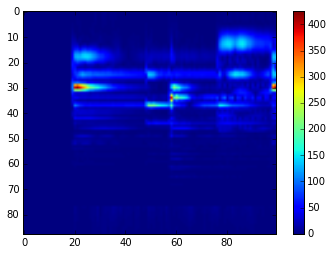

Normalized training set


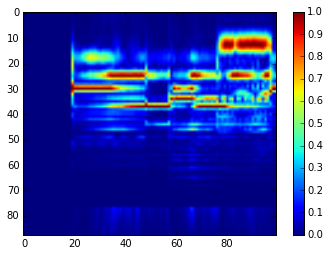

Test set


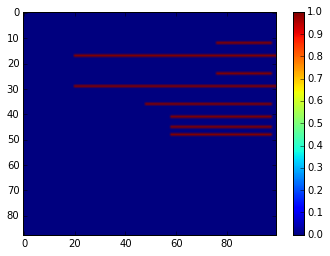

In [119]:
print "Filename: %s" % audio.file_base
print "Rate: %s" % str(audio.rate)
print "Duration: %s" % str(audio.duration)
print "Window: %s" % str(audio.window_size)
print "Hop size: %s" % str(audio.hop_size)
print "Padding: %s" % str(audio.pad)
# print "Notes: %s" % str(audio.notes)
print "Training data (X) size: %s" % str(audio.X.shape)
print "Label (Y) size: %s" % str(audio.Y.shape)
print "\nRaw training set"
plt.figure()
plt.imshow(audio.X[:100].T)
plt.colorbar()
plt.show()
print "Normalized training set"
plt.figure()
plt.imshow(X[:100].T)
plt.colorbar()
plt.show()
print "Test set"
plt.figure()
plt.imshow(audio.Y[:100].T)
plt.colorbar()
plt.show()

In [87]:
class RNNNumpy:
    
    def __init__(self, input_dim, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate # how far back to backprop
        # Randomly initialize the network parameters
        self.U = np.random.uniform(-1 * np.sqrt(1./input_dim), np.sqrt(1./input_dim), (hidden_dim, input_dim))
        self.W = np.random.uniform(-1 * np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
        self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (input_dim, hidden_dim))

In [144]:
def forward_propagation(self, x):
    # The total number of time steps
    T = len(x)
    # During forward propagation we save all hidden states in s because need them later.
    # We add one additional element for the initial hidden, which we set to 0
    s = np.zeros((T + 1, self.hidden_dim))
    s[-1] = np.zeros(self.hidden_dim)
    # The outputs at each time step. Again, we save them for later.
    o = np.zeros((T, self.input_dim))
    # For each time step...
    for t in np.arange(T):
        # Note that we are indxing U by x[t]. This is the same as multiplying U with a one-hot vector.
#         s[t] = np.tanh(self.U[:,x[t]] + self.W.dot(s[t-1]))
#         s[t] = np.tanh(self.U.dot(x[t]) + self.W.dot(s[t-1]))
        s[t] = np.tanh(self.U.dot(x[t]) + self.W.dot(s[t-1]))
        o[t] = softmax(self.V.dot(s[t]))
        plt.figure()
        plt.bar(range(len(o[t])), o[t])
        plt.show()
    return [o, s]

RNNNumpy.forward_propagation = forward_propagation

pitches for one time step


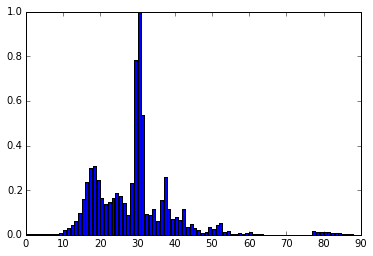

labeled pitch for one time step


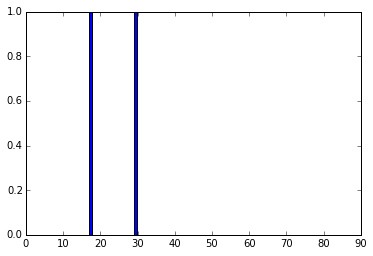

pitches from t=20 to t=21


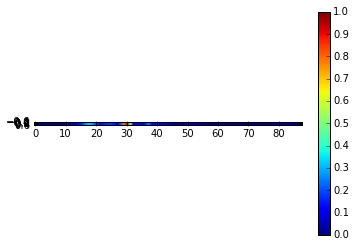

label from t=20 to t=21


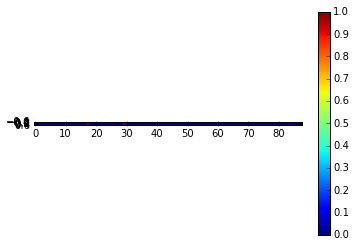

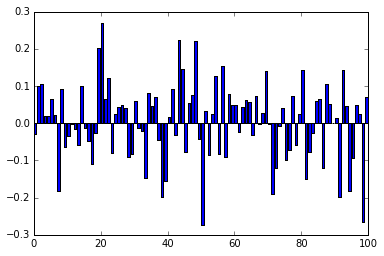

output


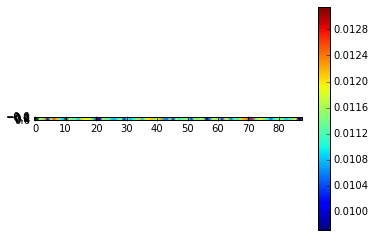

In [142]:
# Forward prop example
np.random.seed(1)
midi_dim = 88
model = RNNNumpy(midi_dim)

i = 20
print "pitches for one time step"
plt.figure()
plt.bar(range(len(X[i])), X[i])
plt.show()

print "labeled pitch for one time step"
plt.figure()
plt.bar(range(len(Y[i])), Y[i])
plt.show()

start = 20
end = 21
print "pitches from t=%d to t=%d" % (start, end)
plt.figure()
plt.imshow(X[start:end, :])
plt.colorbar()
plt.show()

print "label from t=%d to t=%d" % (start, end)
plt.imshow(Y[start:end, :])
plt.colorbar()
plt.show()

o, s = model.forward_propagation(X[start:end, :])
print "output"
plt.figure()
plt.imshow(o)
plt.colorbar()
plt.show()

In [91]:
def predict(self, x):
    # Perform forward propagation and return index of the highest score
    o, s = self.forward_propagation(x)
    return np.argmax(o, axis=1)

RNNNumpy.predict = predict

In [92]:
def calculate_total_loss(self, x, y):
    L = 0
    o, s = self.forward_propagation(x)
    # For each time unit...
    duration = y.shape[0]
    for i in np.arange(duration):
        correct_predictions = np.dot(y[i], np.log(o[i]))
        L += -1 * correct_predictions
    return L

def calculate_loss(self, x, y):
    # Divide the total loss by the number of training examples
    N = np.sum((len(y_i) for y_i in y))
    return self.calculate_total_loss(x,y)/N

RNNNumpy.calculate_total_loss = calculate_total_loss
RNNNumpy.calculate_loss = calculate_loss

Expected Loss for random predictions: 4.477337


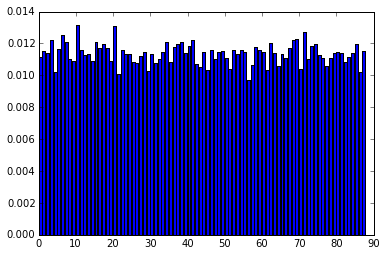

Actual loss: 0.102343


In [145]:
# Limit to 100 examples to save time
midi_dim = 88
start = 20
end = 21
X_sample = X[start:end]
Y_sample = Y[start:end]
print "Expected Loss for random predictions: %f" % np.log(midi_dim)
print "Actual loss: %f" % model.calculate_loss(X_sample, Y_sample)
# print "Actual loss: %f" % model.calculate_total_loss(X, Y)

In [95]:
def bptt(self, x, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(x)
    # We accumulate the gradients in these variables
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = o
    y_on = np.nonzero(y[0].astype(int))[0]
    delta_o[np.ix_(np.arange(len(y)), y_on.T)] -= 1.
    # For each output backwards...
    for t in np.arange(T)[::-1]:
        dLdV += np.outer(delta_o[t], s[t].T)
        # Initial delta calculation
        delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
        # Backpropagation through time (for at most self.bptt_truncate steps)
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
            dLdW += np.outer(delta_t, s[bptt_step-1])
#             print x[bptt_step].astype(int).shape
#             print dLdU.shape
#             dLdU[:, x[bptt_step]] += delta_t
            dLdU += np.outer(delta_t, x[bptt_step])
            # Update delta for next step
            delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    return [dLdU, dLdV, dLdW]

RNNNumpy.bptt = bptt

In [96]:
midi_dim = 88
X_sample = X[40:60]
Y_sample = Y[40:60]
model.bptt(X_sample, Y_sample)

[array([[-0.01771559, -0.01712152, -0.01672856, ..., -0.02282203,
         -0.02047436, -0.01871423],
        [ 0.04542546,  0.04368166,  0.04243243, ...,  0.05908482,
          0.05290059,  0.04819031],
        [-0.0137357 , -0.01311877, -0.01262909, ..., -0.01797893,
         -0.01609768, -0.01463528],
        ..., 
        [ 0.00232685,  0.00216263,  0.00201093, ...,  0.00323805,
          0.0028544 ,  0.00253687],
        [ 0.01289353,  0.01241103,  0.01209297, ...,  0.01691226,
          0.01508602,  0.01369801],
        [-0.00457756, -0.00435361, -0.00419254, ..., -0.00624654,
         -0.00550419, -0.00492787]]),
 array([[ 0.01647235,  0.00788007, -0.01101445, ...,  0.03158036,
         -0.04889527,  0.00166238],
        [ 0.01917013,  0.00888139, -0.01238857, ...,  0.03619738,
         -0.05588929,  0.00181647],
        [ 0.02029281,  0.00936481, -0.01221162, ...,  0.03759662,
         -0.0573703 ,  0.00141722],
        ..., 
        [ 0.02186673,  0.01019341, -0.01338384, ...,

In [97]:
def gradient_check(self, x, y, h=0.001, error_threshold=0.01):
    # Calculate the gradients using backpropagation. We want to checker if these are correct.
    bptt_gradients = model.bptt(x, y)
    # List of all parameters we want to check.
    model_parameters = ['U', 'V', 'W']
    # Gradient check for each parameter
    for pidx, pname in enumerate(model_parameters):
        # Get the actual parameter value from the mode, e.g. model.W
        parameter = operator.attrgetter(pname)(self)
        print "Performing gradient check for parameter %s with size %d." % (pname, np.prod(parameter.shape))
        # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
        it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            ix = it.multi_index
            # Save the original value so we can reset it later
            original_value = parameter[ix]
            # Estimate the gradient using (f(x+h) - f(x-h))/(2*h)
            parameter[ix] = original_value + h
            gradplus = model.calculate_total_loss([x],[y])
            parameter[ix] = original_value - h
            gradminus = model.calculate_total_loss([x],[y])
            estimated_gradient = (gradplus - gradminus)/(2*h)
            # Reset parameter to original value
            parameter[ix] = original_value
            # The gradient for this parameter calculated using backpropagation
            backprop_gradient = bptt_gradients[pidx][ix]
            # calculate The relative error: (|x - y|/(|x| + |y|))
            relative_error = np.abs(backprop_gradient - estimated_gradient)/(np.abs(backprop_gradient) + np.abs(estimated_gradient))
            # If the error is to large fail the gradient check
            if relative_error > error_threshold:
                print "Gradient Check ERROR: parameter=%s ix=%s" % (pname, ix)
                print "+h Loss: %f" % gradplus
                print "-h Loss: %f" % gradminus
                print "Estimated_gradient: %f" % estimated_gradient
                print "Backpropagation gradient: %f" % backprop_gradient
                print "Relative Error: %f" % relative_error
                return 
            it.iternext()
        print "Gradient check for parameter %s passed." % (pname)

RNNNumpy.gradient_check = gradient_check

In [98]:
# Performs one step of SGD.
def numpy_sdg_step(self, x, y, learning_rate):
    # Calculate the gradients
    dLdU, dLdV, dLdW = self.bptt(x, y)
    # Change parameters according to gradients and learning rate
    self.U -= learning_rate * dLdU
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW

RNNNumpy.sgd_step = numpy_sdg_step

In [99]:
# Outer SGD Loop
# - model: The RNN model instance
# - X_train: The training data set
# - y_train: The training data labels
# - learning_rate: Initial learning rate for SGD
# - nepoch: Number of times to iterate through the complete dataset
# - evaluate_loss_after: Evaluate the loss after this many epochs
def train_with_sgd(model, X_train, y_train, learning_rate=0.005, nepoch=100, evaluate_loss_after=5):
    # We keep track of the losses so we can plot them later
    losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        # Optionally evaluate the loss
        if (epoch % evaluate_loss_after == 0):
            loss = model.calculate_loss(X_train, y_train)
            losses.append((num_examples_seen, loss))
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print "%s: Loss after num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss)
            # Adjust the learning rate if loss increases
            if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                learning_rate = learning_rate * 0.5  
                print "Setting learning rate to %f" % learning_rate
            sys.stdout.flush()
        # For each training example...
#         for i in range(len(y_train)):
            # One SGD step
#             print X_train[i]
#             model.sgd_step(X_train[i], y_train[i], learning_rate)
        model.sgd_step(X_train, y_train, learning_rate)
        num_examples_seen += 1

In [100]:
np.random.seed(10)
midi_dim = 88
model = RNNNumpy(midi_dim)
X_sample = X[1:200, :]
Y_sample = Y[1:200, :]

%timeit model.sgd_step(X_sample, Y_sample, 0.005)

10 loops, best of 3: 70.1 ms per loop


In [132]:
# Try with a small batch
np.random.seed(10)
# Train on a small subset of the data to see what happens
midi_dim = 88
model = RNNNumpy(midi_dim)
X_sample = X[1:100, :]
Y_sample = Y[1:100, :]
# predictions = model.predict(X_ex)
losses = train_with_sgd(model, X_sample, Y_sample, learning_rate=0.005, nepoch=10, evaluate_loss_after=1)

2016-03-16 20:25:46: Loss after num_examples_seen=0 epoch=0: 0.193682
2016-03-16 20:25:46: Loss after num_examples_seen=1 epoch=1: 0.193517
2016-03-16 20:25:47: Loss after num_examples_seen=2 epoch=2: 0.193368
2016-03-16 20:25:47: Loss after num_examples_seen=3 epoch=3: 0.193231
2016-03-16 20:25:47: Loss after num_examples_seen=4 epoch=4: 0.193104
2016-03-16 20:25:47: Loss after num_examples_seen=5 epoch=5: 0.192986
2016-03-16 20:25:47: Loss after num_examples_seen=6 epoch=6: 0.192876
2016-03-16 20:25:47: Loss after num_examples_seen=7 epoch=7: 0.192773
2016-03-16 20:25:47: Loss after num_examples_seen=8 epoch=8: 0.192675
2016-03-16 20:25:47: Loss after num_examples_seen=9 epoch=9: 0.192584


output


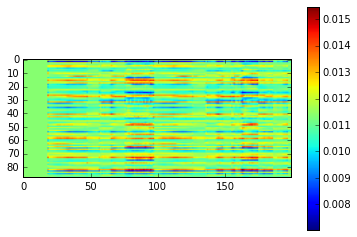

(199, 88)


In [133]:
o, s = model.forward_propagation(X[1:200, :])
print "output"
plt.figure()
plt.imshow(o.T)
plt.colorbar()
plt.show()
print o.shape